In [1]:
import torch
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
from torchvision import transforms
from torchvision import datasets

from ModelDefine import CNN

In [2]:
IMAGE_SIZE=(299,299)

In [3]:
from cnn_finetune import make_model
import torch.nn as nn

def make_classifier(in_features, num_classes):
    return nn.Sequential(
        nn.Linear(in_features, num_classes)
    )

model = make_model('xception', num_classes=120, pretrained=True, input_size=IMAGE_SIZE, classifier_factory=make_classifier)

In [4]:
model.load_state_dict(torch.load('run_2021_01_07-15_10_01_weights_65.pkl'))
model.eval()
model=model.cuda()

In [5]:
from torchsummary import summary
summary(model.cuda(), (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 64, 147, 147]          18,432
       BatchNorm2d-5         [-1, 64, 147, 147]             128
            Conv2d-6         [-1, 64, 147, 147]             576
            Conv2d-7        [-1, 128, 147, 147]           8,192
   SeparableConv2d-8        [-1, 128, 147, 147]               0
       BatchNorm2d-9        [-1, 128, 147, 147]             256
             ReLU-10        [-1, 128, 147, 147]               0
             ReLU-11        [-1, 128, 147, 147]               0
           Conv2d-12        [-1, 128, 147, 147]           1,152
           Conv2d-13        [-1, 128, 147, 147]          16,384
  SeparableConv2d-14        [-1, 128, 1

In [6]:
# get class name
train_data = datasets.ImageFolder('data/train')
class_dir=train_data.class_to_idx
class_list=list(class_dir.keys())
#print(class_list)

In [7]:
image_path="data/predict_image"

In [8]:
images = os.listdir(image_path)

In [9]:
def returnTopN_Predict(images,model,n=5):
    img_tensor = preprocess(images).float()
    img_tensor = img_tensor.unsqueeze_(0)
    img_tensor=img_tensor.cuda()
    fc_out = model(Variable(img_tensor))
    output = fc_out.detach().cpu().numpy()
    
    temp=sorted(range(len(output[0])), key=lambda i: output[0][i])[-n:]
    temp.reverse()
    top_n_result=[]
    for i in (temp):
        temp2=(i,output[0][i])
        top_n_result.append(temp2)
    return top_n_result

In [10]:
# convert data to a normalized torch.FloatTensor
preprocess = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
from PIL import Image
for img_name in images:
    # An instance of your model.
    img_pil = Image.open(image_path+"/"+img_name)
    res=returnTopN_Predict(img_pil,model)
    for i in res:
        print(class_list[i[0]],':',i[1])
    print('========')
    break

n02096585-Boston_bull : 15.918811
n02108089-boxer : 13.5808525
n02108915-French_bulldog : 12.545463
n02110627-affenpinscher : 9.636368
n02110958-pug : 8.576941


In [11]:
res

[(44, 15.918811),
 (91, 13.5808525),
 (94, 12.545463),
 (100, 9.636368),
 (102, 8.576941)]

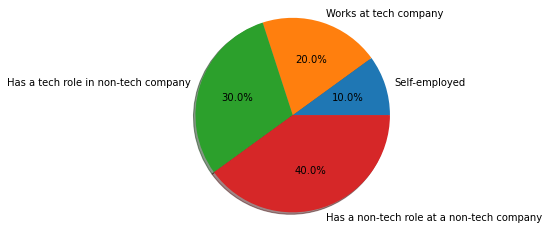

In [13]:
labels = ['Self-employed', 'Works at tech company', 'Has a tech role in non-tech company', 'Has a non-tech role at a non-tech company']
sizes = [10,20,30,40]
# print(sizes) # adds up to 1433, which is the total number of participants
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

In [11]:
# evulate score

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [13]:
test_transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [14]:
test_data = datasets.ImageFolder('data/test', transform=test_transforms)

In [45]:
BATCH_SIZE=1
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [48]:
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
use_cuda = torch.cuda.is_available()
test_v2(test_loader, model, loss_func, use_cuda,n=5)

Test Loss: 1.412954
Test Accuracy: 92% (1104/1200)


In [43]:
def test_v2(loaders, model, criterion, use_cuda,n=5):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        if(len(data)!=1):
            raise Exception('Unsupport batch_size>1 !')
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output2 = output.detach().cpu().numpy()
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label

        temp=sorted(range(len(output2[0])), key=lambda i: output2[0][i])[-n:]
        temp.reverse()
        #top_n_result=[]
        target_=target.detach().cpu().numpy()
        #print("target:",target_)
        for i in (temp):
            #temp2=(i,output2[0][i])
            #top_n_result.append(temp2)
            if(i==target_[0]):
                correct+=1
                break
        #print(top_n_result)
        #for i in 
        #correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))